In [30]:
from mnist import *
import pyro
import pyro.infer
import pyro.optim
import pyro.contrib.autoguide
import pyro.poutine
from tensorboardX import SummaryWriter
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# datasets

use_cuda = False

device = torch.device("cuda" if use_cuda else "cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [ ]:
# regular training

class Args:
    log_interval = 100

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, 10 + 1):
    train(Args(), model, device, train_loader, optimizer, epoch)
    test(Args(), model, device, test_loader)

In [3]:
def geturlattr(obj, url):
    attrs = url.split('.')
    ret = obj
    for attr in attrs:
        ret = getattr(ret, attr)
    return ret

In [4]:
# probabilistic training
elems = [ first + '.' + second for first, second in product(['conv1', 'conv2', 'fc1', 'fc2'], ['weight', 'bias']) ]

net_prob = Net(softmax=False)

def model(X, Y=None):    
    net = pyro.module('net', net_prob)
    logits = net(X)
    pyro.sample('Y', pyro.distributions.Categorical(logits=logits), obs=Y)

def guide(X, Y=None):
    pass

In [13]:
optimizer = pyro.optim.Adamax({'lr':0.001})
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
w = SummaryWriter()

In [6]:
pyro.clear_param_store()

In [ ]:
for epoch in range(50):
    epoch_loss = 0
    for batch, (X, Y) in enumerate(train_loader):
        loss = svi.step(X, Y)
        epoch_loss += loss
        w.add_scalar('batch_loss_epoch%03d' % epoch, loss, batch)
    w.add_scalar('epoch_loss', epoch_loss, epoch)   

In [15]:
P = dict(pyro.get_param_store())

In [63]:
count_cnn = 0
success_cnn = 0
count_cnnp = 0
success_cnnp = 0

for XX, YY in test_loader:
    res_cnn = model(XX)
    res_cnnp = net_prob(XX)
    
    count_cnn += res_cnn.shape[0]
    count_cnnp += res_cnnp.shape[0]
    
    success_cnn += (torch.argmax(res_cnn, dim=1) == YY).sum()
    success_cnnp += (torch.argmax(res_cnnp, dim=1) == YY).sum()

In [64]:
print('CNN: %1.10f' % (float(success_cnn) / float(count_cnn)))

CNN: 0.9900000000


In [76]:
print('CNNP: %1.10f' % (float(success_cnnp) / float(count_cnnp)))

CNNP: 0.9916000000


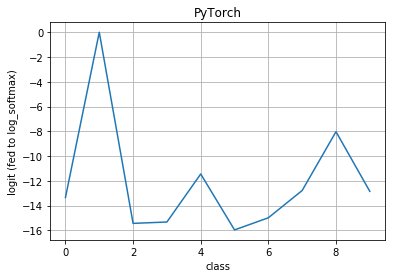

In [73]:
plt.title('PyTorch')
plt.xlabel('class')
plt.ylabel('logit (fed to log_softmax)')
plt.grid()
plt.plot(model(XX[0].unsqueeze(0)).detach().numpy().T)

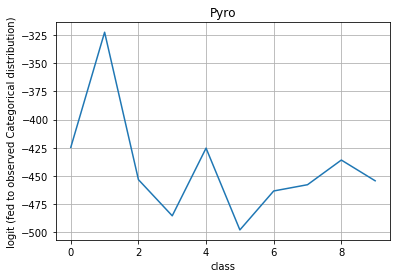

In [75]:
plt.title('Pyro')
plt.xlabel('class')
plt.ylabel('logit (fed to observed Categorical distribution)')
plt.grid()
plt.plot(net_prob(XX[0].unsqueeze(0)).detach().numpy().T)